In [134]:
write("Truss Optimizer.jl",In[IJulia.n])

include("Selection Operators.jl")
include("Crossover Operators.jl")
include("Mutation Operators.jl")

using LinearAlgebra
using Plots

function plot_truss(positions, graph)
    gr(show=:ijulia)
    n=size(positions,1)
    scatter(positions[:,1],positions[:,2],legend=false, names=1:n)
    for i=1:n,j=i+1:n
        if graph[i,j]<=0.0001
            continue
        end
        pts=[i,j]
        plot!(positions[pts,1],positions[pts,2],names=[],lw=3)
    end
end



function energy_deformation(graph,positions,force,dof,E,alpha=0,dT=0)
    n_nodes=size(positions,1)     # number of nodes;
    
    K=zeros(2*n_nodes,2*n_nodes)   # global matrix
    F_nod=zeros((n_nodes*2,))
    F_th=zeros((n_nodes*2,))
    
    for i =1:n_nodes,j=i+1:n_nodes
        if graph[i,j]<=0
            continue
        end
        normal=positions[j,:]-positions[i,:]
        distance=norm(normal)
        normal=normal./distance
        tmp=[-normal ;normal]'
        k=E*graph[i,j]/distance.*tmp'tmp
        f=E*graph[i,j]*alpha*dT*tmp'       # thermal force
        indices=[2 * i-1, 2 * i , 2 * j-1, 2 * j ]
        F_th[indices]+=f
        K[indices,indices]+=k
    end
    
    # Finding displacements
    free=[]
    for i=1:n_nodes
       if dof[i,1]==1
            push!(free,2*i-1)
        end
        if dof[i,2]==1
            push!(free,2*i)
        end
    end

    for i=1:n_nodes
       F_nod[2*i-1] = force[i,1]
       F_nod[2*i] = force[i,2]
    end
    u=zeros((n_nodes*2,))
    u[free]=K[free,free]\(F_nod[free]+F_th[free])*10^3 
    
    # Energy of deformation
    Edef=u'*(K*u/2-F_th)
    
    return Edef
end

# Truss parameters:
positions=[]
force=[]
dof=[]
E=0
distances=[];

function set_truss_parameters(pos,fo,d,e)
    #=
    pos: coordinate of the nodes
    fo: force applied on each node
    d: degrees of freedom
    e: Young's Modulus    
    =#
    n=size(positions,1)
    plot_truss(positions,fill(1,n,n))

    global positions,force,dof,E,distances
    positions=pos
    force=fo
    E=e
    dof=d
    distances=UpperTriangular(zeros(n,n));
    for i=1:n,j=i+1:n
        normal=positions[j,:]-positions[i,:]
        distances[i,j]=norm(normal)
    end
end

function init_population(n_pop,n)
    population=[] 
    for i in 1:n_pop
        push!(population,UpperTriangular(0.01*rand(n,n)))
    end
    return population
end

# fitness is - energy of deformation
function fitness(truss)
    # update the value of cross section of the beam between 1 and 2
    truss[1,2]=0
    sum_la=sum(distances.*truss)
    if sum_la>1
        return 0
    end
    truss[1,2]=(1-sum_la)/distances[1,2]
    try
        return 1/energy_deformation(truss,positions,force,dof,E)
    catch e
        return 0 
    end
end


# Stopping Criteria is convergence of best truss size;
function optimize(n_pop,n_gen)
    population=init_population(n_pop,size(positions,1));
    n_pop=length(population)
    half=Int(round(n_pop/2))

    gr(show = :ijulia)
    display(plot(legend=false))
    last=-1
    step=50
        
    for i in 1:n_gen
        # Fitness Evaluation
        tmp_pop=[]
        sort!(population,by=x->fitness(x));
        fits=fitness.(population)
        # Plotting the fitness
        if last>0 
            if i%step==0
                plot!([i-step,i],[last,1/fits[end]], yaxis=:log)
                last=1/fits[end]
            end
        else
            last=1/fits[end]
        end
        # Selection and Crossover
        for i =1:half
            i,j=selection_operator(fits,[1,2])
            c1,c2=crossover_operator(population[i],population[j],0.4,[2,1,1])
            push!(tmp_pop,c1,c2)
        end
        population=tmp_pop
        
        # Mutation
        population=mutation_operator.(population,0.05)
    end
    
    sort!(population,by=x->fitness(x))
    return population
end

optimize (generic function with 1 method)

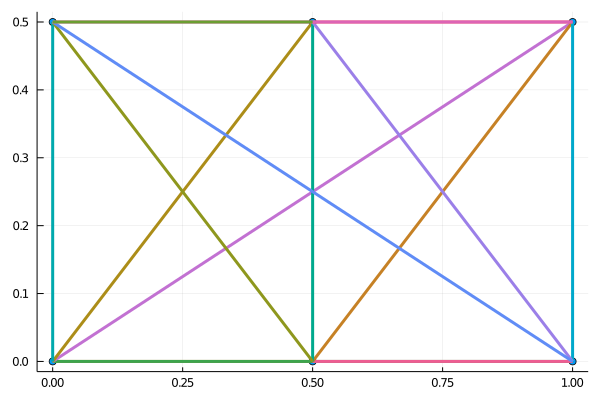

In [135]:
using DelimitedFiles
using DataFrames

io=open("data.txt","r")
data=readdlm(io,'\t',Float64,'\n')
close(io)
data1=DataFrames.DataFrame(data)
# truss parameters
truss_graph= convert(Matrix,data1[:,3:size(data1,2)-3]) #matrice de connectivite
positions= convert(Matrix,data1[:,1:2]) # les coordonnees des noeuds
force=convert(Matrix,data1[:,end-1:end])
dof=convert(Matrix{Int},data1[:,end-2:end-2])
E=20_000
# 
d=zeros(Int(size(dof,1)),2)
for i=1:size(d,1)
    d[i,1] =(dof[i]&1)==0
    d[i,2] =(dof[i]&2)==0
end
set_truss_parameters(positions,force,d,E)

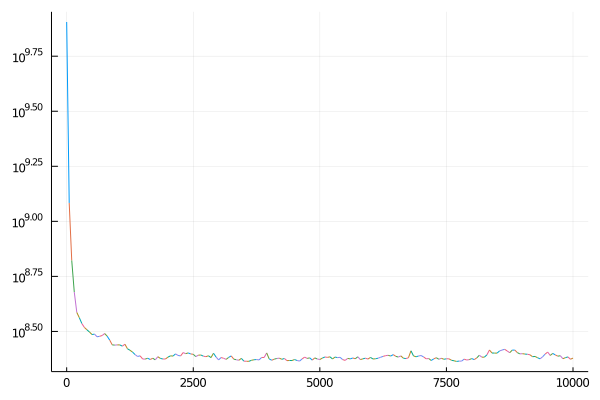

In [138]:
pop=optimize(12,10_000);